In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import time
import random
import pandas as pd

from scipy import signal
from scipy import misc
from scipy.spatial import distance

from ipywidgets import Image
from ipycanvas import Canvas

In [2]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))

In [3]:
img = []
img4 = []
img_orig = []

In [4]:
img = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE);
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB);
img = backtorgb.dot([0.33,0.33,0.33])

(my,mx)=img.shape
img[0,:]=255
img[:,0]=255
img[my-1,:]=255
img[:,mx-1]=255

img_orig = img.copy()

#canvas = Canvas(width=mx, height=my)
image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)
#canvas.put_image_data(image_data,0,0)

In [5]:
#canvas
difftmp = np.array([[1,1,1],[1,0,1],[1,1,1]])
kernel = np.ones((3,3),np.uint8)
img4 = np.zeros_like(img)*0
clas = True
while clas == True:
    img2 = cv2.dilate(img,kernel,iterations = 1)
    img3 = img2-img
    if np.sum(img3)==0:
        break
        
    img4 = img4+(signal.convolve2d(img3,difftmp, boundary='symm', mode='same')/255>4)*255
    
    img3 = img2-img
    image_data = np.stack((img3+img4,img3+img_orig,img3), axis=2)
    #canvas.put_image_data(image_data,0,0)
    #canvas
    img = img2.copy()
image_data = np.stack((img4,img4+img3,img4), axis=2)

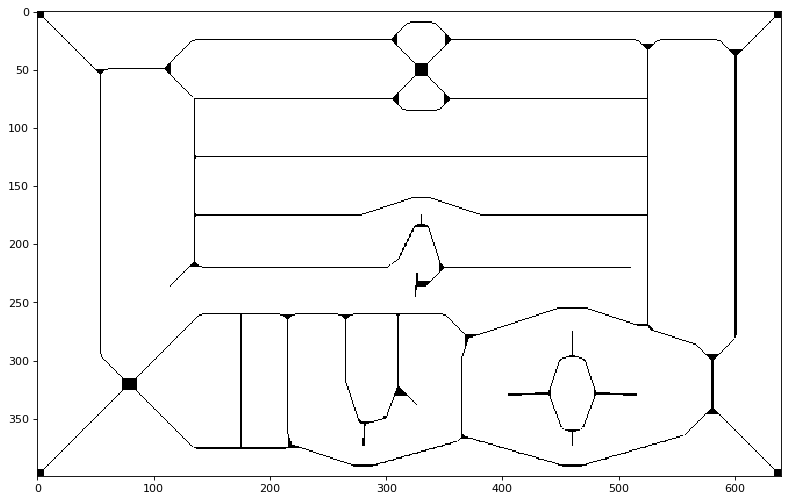

In [31]:
dst = image_data.copy()

kernel = np.ones((3,3),np.uint8)
img5 = cv2.dilate(img4,kernel,iterations = 5)
img5 = cv2.erode(img5,kernel,iterations = 5)
img5 = (255-img5).astype(np.uint8)

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img5, cmap='gray', vmin=0, vmax=255)
plt.show()

In [32]:
contours, hierarchy = cv2.findContours(img5, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [33]:
### Convert OpenCV contours to array of arrays
print(len(contours))
contour_map = []
for i in range(len(contours)):
    
    this_countour = []
    
    for a in contours[i]:
        [x,y]=a[0]
        this_countour.append((x,y))
    contour_map.append(this_countour)

782


#### Convert lines into array of lines
lengths = []
for i in range(len(contour_map)):
    for a in range(len(contour_map[i])-1):
        (sx,sy) = contour_map[i][a]
        (ex,ey) = contour_map[i][a+1]
        
        length = distance.euclidean((sx,sy),(ex,ey))
        if sx<ex:
            lengths.append([sx,sy,ex,ey,length,(ey-sy)/(ex-sx)])
        else:
            lengths.append([ex,ey,sx,sy,length,(sy-ey)/(sx-ex)])

## combine small lines together
nl = []
for i in lengths:
    [psx1,psy1,pex1,pey1,pl,pg]=i
    found=False
    for j in lengths:
        if i!=j:
            [ssx1,ssy1,sex1,sey1,sl,sg]=j
            
            if distance.euclidean((ssx1,ssy1),(psx1,psy1))<2:
                found=True
                [x1,x2,y1,y2]=[sex1,sey1,pex1,pey1]
                break
                
            if distance.euclidean((sex1,sey1),(psx1,psy1))<2:
                found=True
                [x1,x2,y1,y2]=[ssx1,ssy1,pex1,pey1]
                break
                
            if distance.euclidean((ssx1,ssy1),(pex1,pey1))<2:
                found=True
                [x1,x2,y1,y2]=[sex1,sey1,psx1,psy1]
                break
                
            if distance.euclidean((sex1,sey1),(pex1,pey1))<2:
                found=True
                [x1,x2,y1,y2]=[ssx1,ssy1,psx1,psy1]
                break
    
    ## no close
    if not found:
        nl.append(i)
    else:
        length = distance.euclidean((x1,y1),(x2,y2))
        if x1>x2:
            nl.append([x2,y2,x1,y1,length,(y2-y1)/(x2-x1)])
        else:
            nl.append([x1,y1,x2,y2,length,(y1-y2)/(x1-x2)])
                
            

In [34]:
canvas2 = Canvas(width=mx, height=my)
canvas2

Canvas(height=400, width=640)

In [35]:
#### Remove lines that touch Tracks

for i in range(len(contour_map)):
    
    #cv2.drawContours(backtorgb, contours, i, random_color(), 3)
    first = True
    colourr = random_color()
    for a in contour_map[i]:
        (x,y)=a
        
        #print([x,y],sum(sum(img_orig[y-3:y+3,x-3:x+3])))
        minx=max(0,x-3)
        miny=max(0,y-3)
        maxx=min(mx,x+3)
        maxy=min(my,y+3)
        if sum(sum(img_orig[miny:maxy,minx:maxx]))<20:
            if first==True:
                first=False
                x1=x
                y1=y
            else:
                cv2.line(backtorgb,(x,y),(x1,y1),colourr,1)
                x1=x
                y1=y
    image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)
    canvas2.put_image_data(image_data,0,0)
    canvas2
    